# Shift Scheduling

An article entitled ["Modeling and optimization of a weekly workforce with Python and Pyomo"](https://towardsdatascience.com/modeling-and-optimization-of-a-weekly-workforce-with-python-and-pyomo-29484ba065bb) by [Christian Carballo Lozano](https://medium.com/@ccarballolozano) posted in 2018 on the [Towards Data Science](https://towardsdatascience.com/) demonstrated the development of a Pyomo model for scheduling weekly shifts for a small campus food store. The article was primarily intended as a tutorial introduction to Pyomo (see the [github](https://github.com/ccarballolozano/blog-post-codes/blob/master/Modeling-and-optimization-of-a-weekly-workforce-with-Python-and-Pyomo/Modeling%20and%20optimization%20of%20a%20weekly%20workforce%20with%20Python%20and%20Pyomo.ipynb) repository for the code). 

Here we revisit the example with a new model demonstrating  use of Pyomo decorators and of Pyomo Sets.


In [6]:
# install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

installing pyomo . pyomo installed
installing and testing solvers ...
.. glpk installed
.. ipopt failed to download
.. bonmin failed to download
.. couenne failed to download
.. gecode failed to download
.. cbc installed
.. gurobi_direct installed
installation and testing complete


<Figure size 432x288 with 0 Axes>

## Problem Statement

From the original article:

> A new food store has been opened at the University Campus which will be open 24 hours a day, 7 days a week. Each day, there are three eight-hour shifts. Morning shift is from 6:00 to 14:00, evening shift is from 14:00 to 22:00 and night shift is from 22:00 to 6:00 of the next day.

> During the night there is only one worker while during the day there are two, except on Sunday that there is only one for each shift. Each worker will not exceed a maximum of 40 hours per week and have to rest for 12 hours between two shifts.

> As for the weekly rest days, an employee who rests one Sunday will also prefer to do the same that Saturday.
In principle, there are available ten employees, which is clearly over-sized. The less the workers are needed, the more the resources for other stores.

## Analysis

This problem requires assignment of an unspecified number of workers to a predetermined set of shifts. There are three shifts per day, seven days per week. These observations suggest the need for three ordered sets:

* `WORKERS` with $N$ elements representing workers. $N$ is as input to a function creating an instance of the model.

* `DAYS` with labeling the days of the week.

* `SHIFTS` labeling the shifts each day.

The problem describes additional considerations that suggest the utility of several additional sets.

* `SLOTS` is an ordered set of (day, shift) pairs describing all of the available shifts during the week. 

* `BLOCKS` is an order set of all overlapping 24 hour periods in the week. An element of the set contains the (day, shift) period in the corresponding period. This set will be used to limit worker assignments to no more than one for each 24 hour period.

* `WEEKENDS` is a the set of all (day, shift) pairs on a weekend. This set will be used to implement worker perferences on weekend scheduling.

These additional sets improve the readability of the model.

## Modeling

In [7]:
import pyomo.environ as pyo

def shift_schedule(N):

    m = pyo.ConcreteModel('workforce')

    # ordered set of avaiable workers
    m.WORKERS = pyo.Set(initialize=[f"W{i:02d}" for i in range(1, N+1)])

    # ordered sets of days and shifts
    m.DAYS = pyo.Set(initialize=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    m.SHIFTS = pyo.Set(initialize=['morning', 'evening', 'night'])

    # ordered set of day, shift time slots 
    m.SLOTS = pyo.Set(initialize = m.DAYS * m.SHIFTS)

    # ordered set of 24 hour time blocks 
    m.BLOCKS = pyo.Set(initialize = [[m.SLOTS.at(i), m.SLOTS.at(i+1), m.SLOTS.at(i+2)] 
                                     for i in range(1, len(m.SLOTS)-1)])
    
    # ordered set of weekend shifts
    m.WEEKENDS = pyo.Set(initialize = m.SLOTS, filter = lambda m, day, shift: day in ['Sat', 'Sun'])

    # parameter of worker requirements
    @m.Param(m.SLOTS)
    def WorkersRequired(m, day, shift):
        if shift in ['night'] or day in ['Sun']:
            return 1
        return 2

    # decision variable: assign[worker, day, shift] = 1 assigns worker to a time slot
    m.assign = pyo.Var(m.WORKERS, m.SLOTS, domain=pyo.Binary)

    # decision variables: weekend[worker] = 1 worker is assigned weekend shift
    m.weekend = pyo.Var(m.WORKERS, domain=pyo.Binary)

    # decision variable: needed[worker] = 1 
    m.needed = pyo.Var(m.WORKERS, domain=pyo.Binary)

    # determine if a worker is assigned to any shift
    @m.Constraint(m.WORKERS)
    def is_needed(m, worker):
        return len(m.SLOTS)*m.needed[worker] >= sum(m.assign[worker, day, shift] for day, shift in m.SLOTS)

    # determine if a worker is assigned to a weekend shift
    @m.Constraint(m.WORKERS)
    def is__weekend(m, worker):
        return 6*m.weekend[worker] >= sum(m.assign[worker, day, shift] for day, shift in m.WEEKENDS)
                
    # assign a sufficient number of workers for each time slot
    @m.Constraint(m.SLOTS)
    def required_workers(m, day, shift):
        return m.WorkersRequired[day, shift] == sum(m.assign[worker, day, shift] for worker in m.WORKERS)

    # workers limited to forty hours per week assuming 8 hours per shift
    @m.Constraint(m.WORKERS)
    def forty_hour_limit(m, worker):
        return 40 >= 8*sum(m.assign[worker, day, shift] for day, shift in m.SLOTS)

    # workers are assigned no more than one time slot per 24 time block
    @m.Constraint(m.WORKERS, m.BLOCKS)
    def required_rest(m, worker, d1, s1, d2, s2, d3, s3):
        return m.assign[worker, d1, s1] + m.assign[worker, d2, s2] + m.assign[worker, d3, s3] <= 1

    # minimize a blended objective of needed workers and needed weekend workers
    @m.Objective(sense=pyo.minimize)
    def minimize_workers(m):
        return sum(m.needed[worker] + 0.1*m.weekend[worker] for worker in m.WORKERS)

    solver = pyo.SolverFactory('gurobi_direct')
    solver.solve(m)

    return m

m = shift_schedule(10)


## Visualization

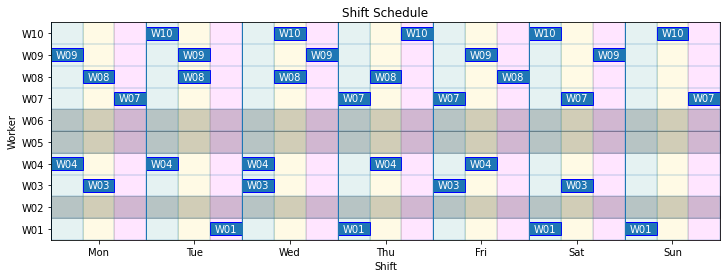

In [44]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize(m):
    bw = 0.6
    workers = [worker for worker in m.WORKERS]
    fig, ax = plt.subplots(1, 1, figsize=(12, 1 + 0.3*len(m.WORKERS)))
    for i, slot in enumerate(m.SLOTS):
        day, shift = slot
        for j, worker in enumerate(m.WORKERS):
            if round(m.assign[worker, day, shift]()):
                ax.add_patch(Rectangle((i, j + (1-bw)/2), 1, bw, edgecolor='b'))
                ax.text(i + 1/2, j + 1/2, worker, ha='center', va='center', color='w')
    for j, worker in enumerate(m.WORKERS):
        if not m.needed[worker]():
            ax.fill_between([0, len(m.SLOTS)], [j, j], [j+1, j+1], color='k', alpha=0.2)

    ax.set_xlim(0, len(m.SLOTS))
    colors = ['teal', 'gold', 'magenta']
    for i in range(len(m.SLOTS) + 1):
        ax.axvline(i, lw=0.3)
        ax.fill_between([i, i+1], [0]*2, [len(m.WORKERS)]*2, alpha=0.1, color=colors[i%3])
    for i in range(len(m.DAYS) + 1):
        ax.axvline(3*i, lw=1)
    ax.set_xticks([3*i + 1.5 for i in range(len(m.DAYS))])
    ax.set_xticklabels(m.DAYS)
    ax.set_xlabel('Shift')

    ax.set_ylim(0, len(m.WORKERS))
    for j in range(len(m.WORKERS) + 1):
        ax.axhline(j, lw=0.3) 
    ax.set_yticks([j + 0.5 for j in range(len(m.WORKERS))])
    ax.set_yticklabels(workers)
    ax.set_ylabel('Worker')

    ax.set_title('Shift Schedule')

visualize(m)


## Reporting

In [43]:
print("Store Staffing Schedule\n")

print("Day    Shift     Staff on Duty")
print("---    -----     -------------")
for day, shift in m.SLOTS:
    print(f"{day}    {shift:7s}   ", end="")
    workers = [worker for worker in m.WORKERS if round(m.assign[worker, day, shift]())]
    print(", ".join(workers))


Store Staffing Schedule

Day    Shift     Staff on Duty
---    -----     -------------
Mon    morning   W04, W09
Mon    evening   W03, W08
Mon    night     W07
Tue    morning   W04, W10
Tue    evening   W08, W09
Tue    night     W01
Wed    morning   W03, W04
Wed    evening   W08, W10
Wed    night     W09
Thu    morning   W01, W07
Thu    evening   W04, W08
Thu    night     W10
Fri    morning   W03, W07
Fri    evening   W04, W09
Fri    night     W08
Sat    morning   W01, W10
Sat    evening   W03, W07
Sat    night     W09
Sun    morning   W01
Sun    evening   W10
Sun    night     W07


In [27]:
# print a schedule for workers
print('Staff Shift Assignments')

for worker in m.WORKERS:
    print(f"\n{worker}:", end="")
    n_shifts = sum(m.assign[worker, day, shift]() for day, shift in m.SLOTS)
    n_weekend_hours = 8*sum(m.assign[worker, day, shift]() for day, shift in m.WEEKENDS)
    if round(n_shifts) == 0:
        print(" no shifts")
    else:
        if n_weekend_hours > 0:
            print(f" {n_weekend_hours} weekend hours", end="")
        print(' ')
        for day, shift in m.SLOTS:
            if round(m.assign[worker, day, shift]()):
                print(f"    {day} {shift}")

Staff Shift Assignments

W01: 16.0 weekend hours 
    Tue night
    Thu morning
    Sat morning
    Sun morning

W02: no shifts

W03: 8.0 weekend hours 
    Mon evening
    Wed morning
    Fri morning
    Sat evening

W04: 
    Mon morning
    Tue morning
    Wed morning
    Thu evening
    Fri evening

W05: no shifts

W06: no shifts

W07: 16.0 weekend hours 
    Mon night
    Thu morning
    Fri morning
    Sat evening
    Sun night

W08: 
    Mon evening
    Tue evening
    Wed evening
    Thu evening
    Fri night

W09: 8.0 weekend hours 
    Mon morning
    Tue evening
    Wed night
    Fri evening
    Sat night

W10: 16.0 weekend hours 
    Tue morning
    Wed evening
    Thu night
    Sat morning
    Sun evening


## Suggested Exercises

1. Modify the objective to spread the shifts out amongst all workers.

2. Add a second class of workers called "manager".  There needs to be one manager on duty for every shift, that morning shifts require 3 staff on duty, evening shifts 2,
and night shifts 1.

3. Add a third class of workers called "part_time". Part time workers are limited to no more than 30 hours per week.

4. Find the minimum cost staffing plan assuming managers cost 30 euros per hour + 100 euros per week in fixed benefits, regular workers cost 20 euros per hour plus 80 euros per week in fixed benefits, and part time workers cosst 15 euros per week with no benefits.